Some of my main findings thus far:
* Started without feature engineering, only performed data cleaning, ended with XGBoost algorithm with Grid Search which gave me roughly 88% training accuracy
* Then followed Sima's excellent feature engineering post, just to get some experience with different techniques for handling different data types, used the same model with Grid Search, and ended with an 83% training accuracy...ended up here that without GridSearch, using the default XGBoost, I was able to get better test set performance (via the submission)
* Next step will be to ensemble the models, using another Kernel

In [468]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [469]:
%matplotlib inline

In [470]:
training = pd.read_csv("train.csv")
testing = pd.read_csv("test.csv")

full_data = [training,testing]

# Data Preprocessing

In [441]:
#Data preprocessing Step 1

#Data conversion
for dataset in full_data:
    
    dataset["Pclass"] = dataset["Pclass"].astype("category")
    dataset["Sex"] = dataset["Sex"].astype("category")
    dataset["Embarked"] = dataset["Embarked"].astype("category")

training["Survived"] = training["Survived"].astype("category")

In [442]:
training["Survived"] = training["Survived"].astype("int64")
training[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [443]:
training[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


# Feature Engineering

In [444]:
#Empty Embarked values, fill with the most common
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
training[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [445]:
#With guidance from Sina, creating a Family Size feature that combines number of siblings/spouse and number of children/parents
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
training[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [446]:
#Creating IsAlone
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
training[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [447]:
#Categorize Fare into buckets
training['CategoricalFare'] = pd.qcut(training['Fare'],4)
training[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [448]:
#To Deal with Age, we can impute values for the 177 missing Ages, then categorize them like the Fare
training['Age'].isnull().sum()

177

In [449]:
#Using mean +/- 2*standard deviation as the range of values that the missing values can take
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg-(2*age_std), age_avg+(2*age_std),size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

/Users/ejenvey/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [450]:
training['CategoricalAge'] = pd.cut(training['Age'],5)
training[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()

,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.402685
1,"(16.0, 32.0]",0.359494
2,"(32.0, 48.0]",0.410256
3,"(48.0, 64.0]",0.421569
4,"(64.0, 80.0]",0.090909


In [451]:
#Apply the binning from the training set to the test set
testing.loc[ testing['Fare'] <= 7.91,'CategoricalFare'] = "(-0.001,7.91]"
testing.loc[(testing['Fare'] > 7.91) & (testing['Fare'] <= 14.454), 'CategoricalFare'] = "(7.91,14.454]"
testing.loc[(testing['Fare'] > 14.454) & (testing['Fare'] <= 31.0), 'CategoricalFare'] = "(14.454, 31.0]"
testing.loc[testing['Fare'] > 31.0, 'CategoricalFare'] = "(31.0, 512.329]"

testing.loc[ testing['Age'] <= 16.0,'CategoricalAge'] = "(-0.08, 16.0]"
testing.loc[(testing['Age'] > 16.0) & (testing['Age'] <= 32.0), 'CategoricalAge'] = "(16.0, 32.0]"
testing.loc[(testing['Age'] > 32.0) & (testing['Age'] <= 48.0), 'CategoricalAge'] = "(32.0, 48.0]"
testing.loc[(testing['Age'] > 48.0) & (testing['Age'] <= 64.0), 'CategoricalAge'] = "(48.0, 64.0]"
testing.loc[ testing['Age'] > 64.0,'CategoricalAge'] = "(64.0, 80.0]"

In [452]:
for dataset in full_data:
    dataset["FamilySize"] = dataset["FamilySize"].astype("category")
    dataset['IsAlone'] = dataset['IsAlone'].astype('category')
    dataset['CategoricalFare'] = dataset['CategoricalFare'].astype('category')
    dataset['CategoricalAge'] = dataset['CategoricalAge'].astype('category')

# One-hot encoding

In [453]:
for column in training.select_dtypes(include=['category']).columns:
    dummy_columns = pd.get_dummies(data=training[column],prefix=column)
    training = pd.merge(training, pd.DataFrame(dummy_columns.iloc[:,1:]), left_index=True, right_index=True)

In [454]:
for column in testing.select_dtypes(include=['category']).columns:
    dummy_columns = pd.get_dummies(data=testing[column],prefix=column)
    testing = pd.merge(testing, pd.DataFrame(dummy_columns.iloc[:,1:]), left_index=True, right_index=True)

In [455]:
for column in training.select_dtypes(include=['uint8']).columns:
    training[column] = training[column].astype(np.int32)

for column in testing.select_dtypes(include=['uint8']).columns:
    testing[column] = testing[column].astype(np.int32)

# Visualization

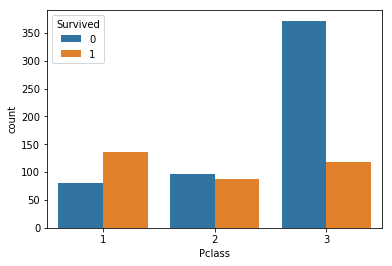

In [165]:
sns.countplot(x="Pclass",hue="Survived",data=training)

In [ ]:
fig, axes = plt.subplots()
training[training['Survived']==0]['Fare'].hist(bins=100)
axes.set_xlim(0,100)

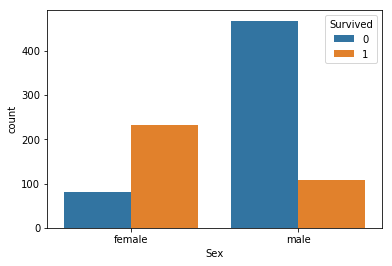

In [27]:
sns.countplot(x="Sex",hue="Survived",data=training)

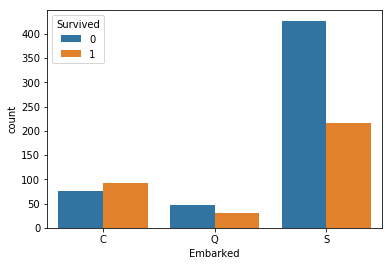

In [29]:
sns.countplot(x="Embarked",hue="Survived",data=training)

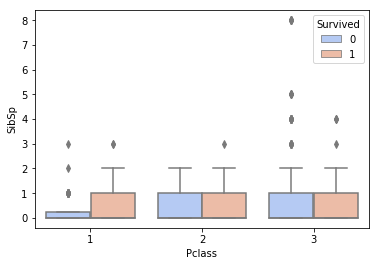

In [38]:
sns.boxplot(x="Pclass", y="SibSp", hue="Survived",data=training, palette="coolwarm")

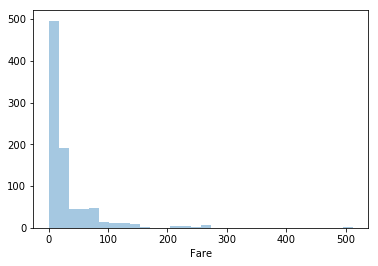

In [41]:
sns.distplot(training["Fare"], kde=False, bins=30)

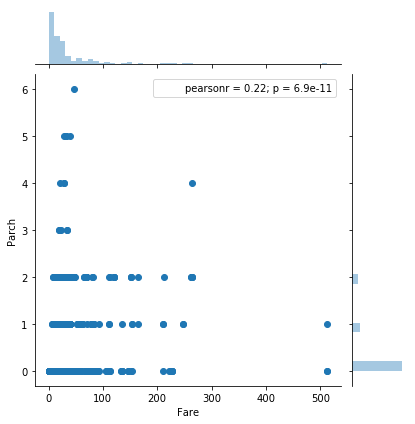

In [48]:
sns.jointplot(x="Fare", y="Parch",data=training,kind='scatter')

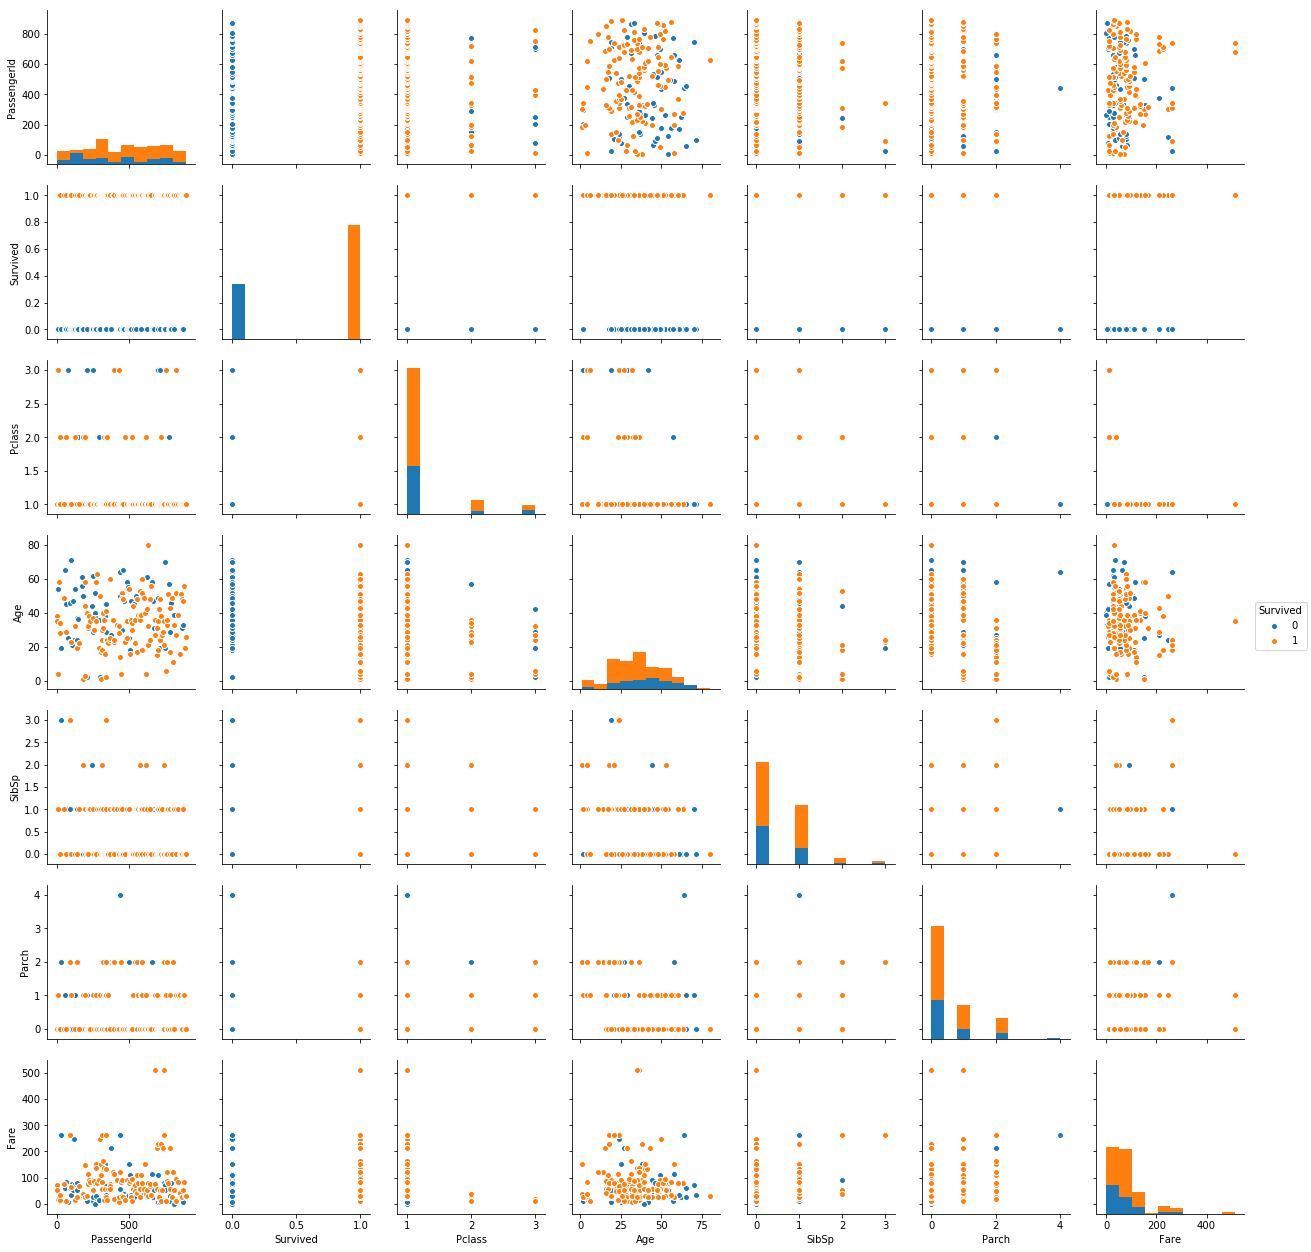

In [57]:
sns.pairplot(training.dropna(),hue="Survived")

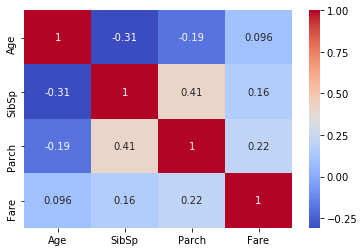

In [58]:
sns.heatmap(training.corr(),cmap='coolwarm',annot=True)

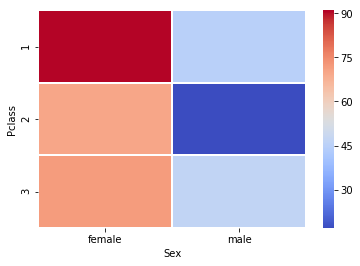

In [67]:
pv_Pclass_Gender_Survived = training.pivot_table(values='Survived',index='Pclass',columns='Sex',aggfunc='sum')
sns.heatmap(pv_Pclass_Gender_Survived, cmap='coolwarm',linecolor='white',linewidths=1)

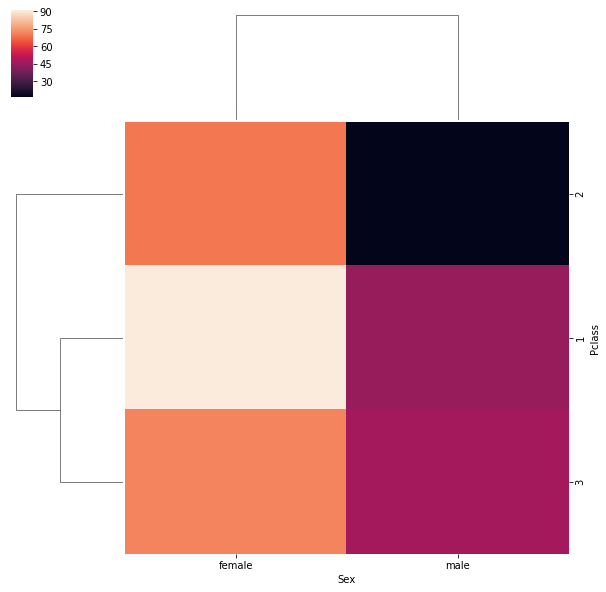

In [68]:
sns.clustermap(pv_Pclass_Gender_Survived)

In [71]:
#training["CabinClass"] = training["Cabin"].astype("str").apply(lambda x: x[0])

#training["CabinClass"] = training["CabinClass"].astype("category")

**Below table shows Cabin Class is almost equivalent to Pclass, so we'll comment it out**

In [78]:
#training.pivot_table(values='Survived',index='CabinClass',columns='Pclass',aggfunc='sum')

Pclass,1,2,3
CabinClass,,,
A,7.0,NaN,NaN
B,35.0,NaN,NaN
C,35.0,NaN,NaN
D,22.0,3.0,NaN
E,18.0,3.0,3.0
F,NaN,7.0,1.0
G,NaN,NaN,2.0
T,0.0,NaN,NaN
n,19.0,74.0,113.0


**Saving the below code, but did not end up using, as Cabin Class ends up being very similar to Pclass**

In [5]:
#Create a Cabin class variable
#training["CabinClass"] = training["Cabin"].astype("str").apply(lambda x: x[0])
#testing["CabinClass"] = testing["Cabin"].astype("str").apply(lambda x: x[0])

#training["CabinClass"] = training["CabinClass"].astype("category")
#testing["CabinClass"] = testing["CabinClass"].astype("category")

#testing["CabinClass"].cat.add_categories(["T"])

# Data Preprocessing

In [456]:
training= training.drop(['Age','SibSp','Parch','Pclass','Sex','Embarked','FamilySize','IsAlone','CategoricalFare','CategoricalAge','Name','Ticket','Fare','Cabin'],axis=1)
testing= testing.drop(['Age','SibSp','Parch','Pclass','Sex','Embarked','FamilySize','IsAlone','CategoricalFare','CategoricalAge','Name','Ticket','Fare','Cabin'],axis=1)


In [158]:
#No longer need the below step, as all numeric variables have been binned

#from sklearn.preprocessing import StandardScaler
#Feature Scaling
    
#scaled_training_features = training.copy()
#scaled_testing_features = testing.copy()

#col_names_train = list(training.select_dtypes(include=["float","int"]).columns)
#col_names_test = list(testing.select_dtypes(include=["float","int"]).columns)

#features_train = scaled_training_features[col_names_train]
#features_test = scaled_testing_features[col_names_test]

#scaler_train = StandardScaler().fit(features_train.values)
#scaler_test = StandardScaler().fit(features_test.values)

#features_train = scaler_train.transform(features_train.values)
#features_test = scaler_test.transform(features_test.values)

#scaled_training_features[col_names_train] = features_train
#scaled_testing_features[col_names_test] = features_test

/Users/ejenvey/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Data Modeling

In [457]:
y_train = training.iloc[:,1]
X_train = training.drop(["Survived","PassengerId"],axis=1)
X_test = testing.drop(["PassengerId"], axis=1)

In [458]:
#For XGBoost, must remove [] from variable names:
X_train.columns = [['Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'FamilySize_2', 'FamilySize_3', 'FamilySize_4', 'FamilySize_5',
       'FamilySize_6', 'FamilySize_7', 'FamilySize_8', 'FamilySize_11',
       'IsAlone_1', 'CategoricalFare_(7.91-14.454)',
       'CategoricalFare_(14.454-31.0)', 'CategoricalFare_(31.0-512.329)',
       'CategoricalAge_(16.0-32.0)', 'CategoricalAge_(32.0-48.0)',
       'CategoricalAge_(48.0-64.0)', 'CategoricalAge_(64.0-80.0)']]
X_test.columns = [['Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'FamilySize_2', 'FamilySize_3', 'FamilySize_4', 'FamilySize_5',
       'FamilySize_6', 'FamilySize_7', 'FamilySize_8', 'FamilySize_11',
       'IsAlone_1', 'CategoricalFare_(7.91-14.454)',
       'CategoricalFare_(14.454-31.0)', 'CategoricalFare_(31.0-512.329)',
       'CategoricalAge_(16.0-32.0)', 'CategoricalAge_(32.0-48.0)',
       'CategoricalAge_(48.0-64.0)', 'CategoricalAge_(64.0-80.0)']]

In [401]:
#Fitting XGBoost to the Training Set
from xgboost import XGBClassifier
classifier = XGBClassifier(learning_rate=1, gamma=0.2,max_depth=2, n_estimators=200,base_score=0.1,min_child_weight=1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.2, learning_rate=1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [402]:
#Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
#in the below dictionary, we create two entries which contain the parameters as keys and the parameter settings that we want to test out as the values
parameters = {'booster': ['gbtree'],'subsample':[1],'scale_pos_weight':[1],'reg_lambda':[1],'reg_alpha':[1],'learning_rate':[1],'gamma':[0.2],'max_depth':[2],'n_estimators':[200],'base_score':[0.1],'min_child_weight':[1]}
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)

In [403]:
#gives us a list of the best parameters selected
best_params = grid_search.best_params_

In [404]:
best_params

{'base_score': 0.1,
 'booster': 'gbtree',
 'gamma': 0.2,
 'learning_rate': 1,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 200,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1}

In [405]:
#Predict the Test set results
y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

In [406]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_train)
cm

array([[514,  35],
       [116, 226]])

In [407]:
accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[1,0]+cm[0,1]).astype(float)
accuracy

0.83052749719416386

In [416]:
feature_Dataframe = pd.DataFrame({'features' : X_train.columns.values, 'Feature Importance': classifier.feature_importances_})

/Users/ejenvey/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


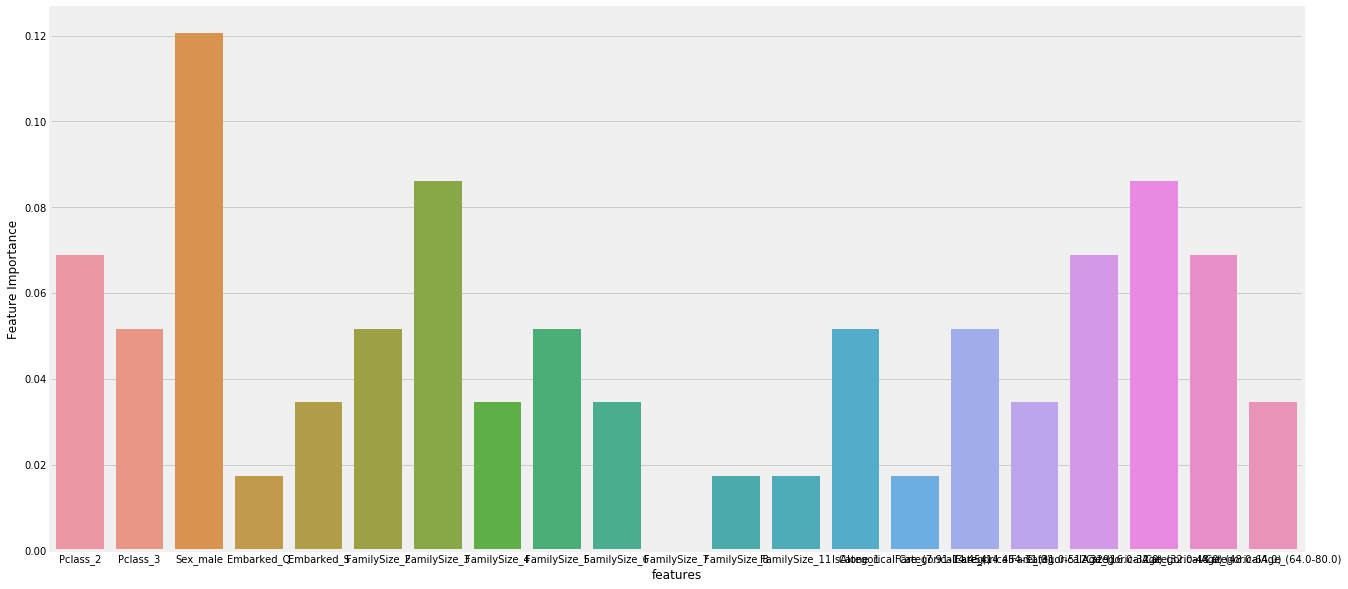

In [419]:
fig, axes = plt.subplots(figsize=(20,10))
sns.barplot(x='features', y='Feature Importance',data=feature_Dataframe)

# Ensemble

In this next section, I attempt to use Stacking to improve the accuracy of the prediction.  Credit to Arthurtok for the inspiration behind this

In [423]:
# Some useful parameters which will come in handy later on
ntrain = training.shape[0]
ntest = testing.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

In [464]:
X_train.shape

(891, 21)

In [429]:
#I do not understand this part, need to gain understanding here in order to really understand the ensemble.  He says "you cannot train the base models on the full training data, generate predictions of the test set, then output these for the second-level training"
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        #changed this to fit, I didn't override scikit-learn
        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In order to ensemble, I will need to generate multiple models, will start with the same ones he uses, in addition to my XGBoost above

In [421]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

/Users/ejenvey/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [425]:
rf = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 500,
                            criterion = "entropy",
                            warm_start = True,
                            max_depth = 6,
                            min_samples_leaf = 2,
                            max_features = 'sqrt',
                            verbose=0,
                            random_state = 0)
#rf.fit(X_train, y_train)

et = ExtraTreesClassifier(n_jobs = -1,
                         n_estimators = 500,
                         max_depth = 8,
                         min_samples_leaf = 2,
                         verbose = 0)
#et.fit(X_train,y_train)

ada = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.75)
#ada.fit(X_train,y_train)

gb = GradientBoostingClassifier(n_estimators = 500,
                               max_depth = 5,
                               min_samples_leaf = 2,
                               verbose = 0)
#gb.fit(X_train, y_train)

svc = SVC(kernel = 'linear', C = 0.025)
#svc.fit(X_train, y_train)

In [459]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = y_train.ravel()
x_train = X_train.values # Creates an array of the train data
x_test = X_test.values # Creats an array of the test data

In [460]:

# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

ValueError: Number of features of the model must match the input. Model n_features is 22 and input n_features is 21 

In [432]:
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
ada_feature = ada.feature_importances_
gb_feature = gb.feature_importances_

In [435]:
cols = training.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [436]:
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.868,0.035853,0.700904,0.100185,PassengerId
1,0.008,0.029135,0.020564,0.027532,Pclass_2
2,0.008,0.132200,0.024035,0.150305,Pclass_3
3,0.016,0.481641,0.040050,0.360136,Sex_male
4,0.002,0.013163,0.004681,0.009908,Embarked_Q
5,0.006,0.034822,0.028052,0.036563,Embarked_S
6,0.000,0.017293,0.016883,0.030939,FamilySize_2
7,0.002,0.024942,0.005615,0.024407,FamilySize_3
8,0.000,0.015075,0.004647,0.015662,FamilySize_4
9,0.008,0.014878,0.002011,0.007604,FamilySize_5


In [408]:
output = pd.DataFrame(scaled_testing_features["PassengerId"])
output["Survived"] = y_pred

In [409]:
output.to_csv("output.csv", index=False)